# Problem Statement

Ecommerce company is evaluating the customer experience. So they run a survey among the customers to understand the feedback from the customers. They see that late delivery is one most frequent problem faced by the customer. However, the consumer experience manager says that the late delivery % is similar to industry average. We should do hypothesis test to compare organization with industry average which is 0.06.

Establish the fact that organization has a poor record in delivery. Evaluate the current algorithm to estimate delivery. The current algo is simplistic. We decide to build a intelligent system which predict delivery date by taking lot of factor into account. We roll out this algorithm for 10% of customer. Compare complaint % between the two samples 

# Solution

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind, ztest
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import tt_ind_solve_power
import scipy.stats as sc
from scipy.stats import binom, norm, ttest_rel
from IPython.display import Image

In [36]:
orders = pd.read_csv('ecommerce_orders.csv')

pd.to_datetime(orders["order_estimated_delivery_date"][0])

Timestamp('2017-02-07 00:00:00')

In [6]:
# Reading reviews data
reviews = pd.read_csv('ecommerce_reviews.csv')

reviews.columns

Index(['review_id', 'review_score', 'review_creation_date', 'review_title',
       'order_id'],
      dtype='object')

In [116]:
# Merging the orders dataset with the reviews dataset
order_reviews = pd.merge(orders, reviews, how='left', left_on='order_id', right_on= 'order_id')

In [118]:
# Removing any missing values in the order_ids and delivery dates
order_reviews = order_reviews.dropna(subset = ['order_id', 'order_delivered_customer_date'])

In [10]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61005 entries, 0 to 61004
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       61005 non-null  object
 1   customer_id                    61005 non-null  object
 2   order_status                   61005 non-null  object
 3   order_purchase_timestamp       61005 non-null  object
 4   order_approved_at              60991 non-null  object
 5   order_delivered_carrier_date   61004 non-null  object
 6   order_delivered_customer_date  61005 non-null  object
 7   order_estimated_delivery_date  61005 non-null  object
 8   review_id                      61005 non-null  object
 9   review_score                   61005 non-null  int64 
 10  review_creation_date           61005 non-null  object
 11  review_title                   24912 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.1+ MB


In [119]:
# Sorting the value by the date
order_reviews = order_reviews.sort_values(by='order_delivered_customer_date').reset_index(drop=True)

In [120]:
# Removing duplicate values from the order_reviews dataset
order_reviews = order_reviews.drop_duplicates(subset='order_id')

In [121]:
# Dropping columns irrelevant to the problem statement
order_reviews = order_reviews.drop(columns = ['customer_id', 'order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date'])

### 1. Establish the fact that organization has a poor record in delivery. 

(-10.0, 60.0)

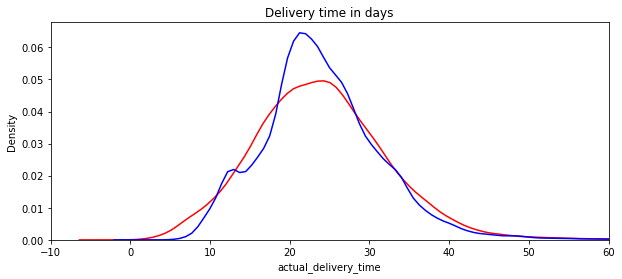

In [122]:
# Comparing the actual delivery time against the estimated delivery time

# Converting all the dates to pandas datetime format
order_reviews['order_approved_at'] = pd.to_datetime(order_reviews['order_approved_at'])
order_reviews['order_estimated_delivery_date'] = pd.to_datetime(order_reviews['order_estimated_delivery_date'])
order_reviews['order_delivered_customer_date'] = pd.to_datetime(order_reviews['order_delivered_customer_date'])

# Calculate actual delivery time from customer buying the product to receiveing the product
order_reviews['actual_delivery_time'] = (order_reviews['order_delivered_customer_date'] - order_reviews['order_approved_at']).dt.total_seconds() / 86400

# Calculating the estimated delivery time
order_reviews['estimated_delivery_time'] = (order_reviews['order_estimated_delivery_date'] - order_reviews['order_approved_at']).dt.total_seconds() / 86400

# Comparing the actual delivery time and estimated delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")

ax1 = sns.kdeplot(order_reviews['actual_delivery_time'].dropna(), color="red", label='Actual Delivery time')
ax2 = sns.kdeplot(order_reviews['estimated_delivery_time'].dropna(), color="blue", label='Estimated delivery time')

plt.xlim(-10, 60)

### Comparing the means between **'actual_delivery_time'** and **'estimated_delivery_time'**

In [123]:
# Testing for a significant difference between the estimated delivery time and actual delivery time
sample1 = np.array(order_reviews['actual_delivery_time'].dropna())
sample2 = np.array(order_reviews['estimated_delivery_time'].dropna())

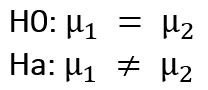

In [124]:
Image('Hypothesis_comparing_means.png')

### Testing matched samples t tests

In [125]:
# Matched sample test
t_statistic, p_value = ttest_rel(sample1, sample2)

In [126]:
α = 0.05

# Checking p value against α
if p_value < α:
    print('P value = ', p_value)
    print('Reject H0')
    print('There is a significant difference between the estimated delivery time and actual delivery time')
else:
    print('P value = ', p_value)
    print('Cannot Reject H0')

P value =  1.1313533589878193e-09
Reject H0
There is a significant difference between the estimated delivery time and actual delivery time


In [127]:
pd.to_datetime("19042021", format="%d%m%Y").month

4

In [128]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61005 entries, 0 to 61004
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       61005 non-null  object        
 1   order_approved_at              60991 non-null  datetime64[ns]
 2   order_delivered_customer_date  61005 non-null  datetime64[ns]
 3   order_estimated_delivery_date  61005 non-null  datetime64[ns]
 4   review_id                      61005 non-null  object        
 5   review_score                   61005 non-null  int64         
 6   review_creation_date           61005 non-null  object        
 7   review_title                   24912 non-null  object        
 8   actual_delivery_time           60991 non-null  float64       
 9   estimated_delivery_time        60991 non-null  float64       
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 5.1+ MB


In [129]:
# Frequency of reviews given by customers
order_reviews.review_title.value_counts()

Late Delivery             3985
Great Customer Service    3170
Great product             3035
Bad Quality               2996
Wrong Product             2975
Product was broken        2964
Bad Customer Service      2946
Not User Friendly         2841
Name: review_title, dtype: int64

In [130]:
# Weekly Analysis of the reviews

# Week number when the customer recieved the delivery
order_reviews['delivery_week'] = order_reviews['order_delivered_customer_date'].dt.week.astype(str)

# Year number when the customer recieved the delivery
order_reviews['delivery_year'] = order_reviews['order_delivered_customer_date'].dt.year.astype(str)

# Creating a unique identifier for the week and the year of the date when the order was delivered
order_reviews['delivery_year_week'] = order_reviews['delivery_year'] + order_reviews['delivery_week']

<ipython-input-130-70738250db86>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_reviews['delivery_week'] = order_reviews['order_delivered_customer_date'].dt.week.astype(str)


In [131]:
pd.set_option('display.max_rows', order_reviews.shape[0]+1)

In [132]:
 df = pd.DataFrame(
   ...:     [
   ...:         ("bird", "Falconiformes", 389.0),
   ...:         ("bird", "Psittaciformes", 24.0),
   ...:         ("mammal", "Carnivora", 80.2),
   ...:         ("mammal", "Primates", np.nan),
   ...:         ("mammal", "Carnivora", 58),
   ...:     ],
   ...:     index=["falcon", "parrot", "lion", "monkey", "leopard"],
   ...:     columns=("class", "order", "max_speed"),
   ...: )

In [73]:
type(df)

pandas.core.frame.DataFrame

In [72]:
func = lambda x:x
df.groupby("class").apply(func)

TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [79]:
def myFunc(x):
    if(x["max_speed"]>50):
        return x
    else:
        return 0

df.apply(lambda x:x["max_speed"]>50, axis=1)

# df.apply(myFunc, axis=1)


falcon      True
parrot     False
lion        True
monkey     False
leopard     True
dtype: bool

In [76]:
df

,class,order,max_speed
falcon,bird,Falconiformes,389.0
parrot,bird,Psittaciformes,24.0
lion,mammal,Carnivora,80.2
monkey,mammal,Primates,NaN
leopard,mammal,Carnivora,58.0


In [87]:
df.groupby("class")["order"].value_counts()

class   order         
bird    Falconiformes     1
        Psittaciformes    1
mammal  Carnivora         2
        Primates          1
Name: order, dtype: int64

In [60]:
def countOfLateDeliveries(x):
    if(x and x=="Late Delivery"):
        return x

#     return len(x)

In [133]:
order_reviews.groupby(["delivery_year_week"])['review_title'].apply(lambda x:x.value_counts())

delivery_year_week                        
201710              Late Delivery              31
                    Not User Friendly          25
                    Bad Customer Service       24
                    Great Customer Service     24
                    Bad Quality                23
                    Wrong Product              23
                    Great product              22
                    Product was broken         19
201711              Late Delivery              37
                    Bad Quality                36
                    Wrong Product              34
                    Bad Customer Service       32
                    Great product              31
                    Great Customer Service     30
                    Product was broken         30
                    Not User Friendly          28
201712              Bad Customer Service       43
                    Late Delivery              42
                    Wrong Product              33
       

In [139]:
n = order_reviews[order_reviews["review_title"] == "Late Delivery"].groupby("delivery_year_week")["review_title"].count()
# order_reviews.groupby(["delivery_year_week"]).apply(lambda x:x)

# order_reviews.groupby(["delivery_year_week"]).count()

In [17]:
# Most common review on a weekly basis
order_reviews.groupby(['delivery_year_week'])['review_title'].apply(lambda x:x.value_counts().index[0])

delivery_year_week
201710             Late Delivery
201711             Late Delivery
201712      Bad Customer Service
201713             Late Delivery
201714               Bad Quality
201715             Late Delivery
201716             Late Delivery
201717             Late Delivery
201718             Great product
201719        Product was broken
201720             Late Delivery
201721      Bad Customer Service
201722             Late Delivery
201723             Late Delivery
201724             Late Delivery
201725             Great product
201726               Bad Quality
201727             Late Delivery
201728             Late Delivery
201729             Late Delivery
201730        Product was broken
201731             Late Delivery
201732    Great Customer Service
201733             Late Delivery
201734             Late Delivery
201735             Late Delivery
201736             Late Delivery
201737    Great Customer Service
201738             Late Delivery
201739             Late 

In [18]:
# Using this function, you can adjust the number of rows you want to be displayed while printing the dataframe
pd.set_option('display.max_rows', 10)

### Testing proportion of Late Delivery reviews

In [140]:
# Count of Late Delivery orders per week
num_late_delivery_weekly = order_reviews.groupby(order_reviews.delivery_year_week).review_title.apply(lambda x: (x=='Late Delivery').sum())

print(num_late_delivery_weekly.head())
print(n.head())

delivery_year_week
201710    31
201711    37
201712    42
201713    44
201714    33
Name: review_title, dtype: int64
delivery_year_week
201710    31
201711    37
201712    42
201713    44
201714    33
Name: review_title, dtype: int64


In [141]:
# Count of orders per week
num_orders_weekly = order_reviews.groupby(order_reviews.delivery_year_week).order_id.count()

In [143]:
proportion_late_deliveries = num_late_delivery_weekly/ num_orders_weekly

proportion_late_deliveries2 = n/ num_orders_weekly

print(proportion_late_deliveries.head())

print(proportion_late_deliveries2.head())

delivery_year_week
201710    0.065678
201711    0.059105
201712    0.060258
201713    0.071778
201714    0.053834
dtype: float64
delivery_year_week
201710    0.065678
201711    0.059105
201712    0.060258
201713    0.071778
201714    0.053834
dtype: float64


### 2) Conduct a hypothesis test to compare the organization late delivery % with the industry average which is 6%

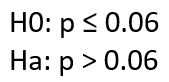

In [22]:
Image('Hypothesis_Testing_proportion_.png')

In [145]:
successes = np.sum(num_late_delivery_weekly)

successes2 = np.sum(n)

sample_size = np.sum(num_orders_weekly)

In [149]:
z_statistic, p_value = proportions_ztest(successes, sample_size, value = 0.06, alternative = 'larger')


z_statistic2, p_value2 = proportions_ztest(successes2, sample_size, value = 0.06, alternative = 'larger')


print(p_value,p_value2)

5.179425725521796e-08 5.179425725521796e-08


#### **Note:** <br>

**Ha: p < 0.06 (1 tailed test)**<br>
alternative = 'smaller'

**Ha: p > 0.06 (1 tailed test)**<br>
alternative = 'larger'

**Ha: p != 0.06 (2 tailed test)**<br>
alternative = 'two-sided'

In [25]:
p_value

5.179425725521796e-08

In [150]:
α = 0.05

# Checking p value against α
if p_value < α:
    print('P value = ', p_value)
    print('Reject H0')
    print('The proportion of Late Delivery complaints is > 0.06')
else:
    print('P value = ', p_value)
    print('Cannot Reject H0')
    print('The proportion of Late Delivery complaints is <= 0.06')

P value =  5.179425725521796e-08
Reject H0
The proportion of Late Delivery complaints is > 0.06


### 3) A/B Testing

#### Compare late delivery complaint % before and after the algorithm was rolled out.

In [153]:
ab_testing_orders = pd.read_csv('ab_testing_orders.csv')
ab_testing_reviews = pd.read_csv('ab_testing_reviews.csv')


print(ab_testing_orders.head())
# print(ab_testing_reviews.head())

                           order_id                       customer_id  \
0  865aee0fd5873d8a2974df861e2526ef  622c8e6dd2f3d6f07a232257ee86e6b9   
1  39e0115911bf404857e14baa7f097feb  816642e9995c2461f2172469e78c7370   
2  38930f76efb00b138f4d632e4d557341  0f9043c635f86f7eb1e8fc07704df303   
3  7b875e17a8b649ecb72124320bdfd20f  399c6c81654067bed2b65f0265f1282b   
4  933fc5257a9b5a80bd558f2968d7b6f3  7128a6c72181215d6e1358918a66c845   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2018-01-07 20:49:50  2018-01-07 21:31:45   
1    delivered      2018-01-20 07:48:16  2018-01-20 09:15:46   
2    delivered      2018-01-28 13:47:42  2018-01-28 14:00:18   
3    delivered      2018-01-28 22:45:22  2018-01-28 22:53:23   
4    delivered      2018-01-29 11:03:03  2018-01-30 04:31:05   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2018-01-24 18:15:05           2018-04-17 22:42:11   
1          2018-01-23 18:27:00           2018-04

In [154]:
# Merging the orders dataset with the reviews dataset
ab_testing_orders_reviews = pd.merge(ab_testing_orders, ab_testing_reviews, how='left', left_on='order_id', right_on= 'order_id')

In [155]:
# Number of customers in the Treatment group and Control group
ab_testing_orders_reviews.group.value_counts()

Treatment    18235
Control      15000
Name: group, dtype: int64

In [156]:
# Creating a new column, Delivery_Complaint
# Delivery_Complaint = True if review_title = Late Delivery, else False
ab_testing_orders_reviews['Delivery_Complaint'] = ab_testing_orders_reviews['review_title'].apply(lambda x: x == 'Late Delivery')

In [157]:
# 'True' is the number of orders in the dataset having delivery complaints
# 'False' is the number of orders in the dataset not having a delivery complaint
ab_testing_orders_reviews['Delivery_Complaint'].value_counts()

False    31267
True      1968
Name: Delivery_Complaint, dtype: int64

In [158]:
# Number of Delivery complains in the Control and Treatment Groups
successes = ab_testing_orders_reviews.groupby('group')['Delivery_Complaint'].sum()

In [159]:
successes

group
Control      1013
Treatment     955
Name: Delivery_Complaint, dtype: int64

In [160]:
# Sample Size taken for the Control and Treatment Groups
# This counts the number of True values in the Control and Treatment groups. Remember, True means review_title = Late Delivery
sample_size = ab_testing_orders_reviews.groupby('group')['order_id'].count()

In [166]:
proportions = successes/ sample_size

print(proportions.head())

group
Control      0.067533
Treatment    0.052372
dtype: float64


### With Library

### **Hypothesis**

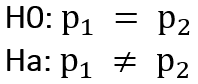

In [36]:
Image('proportions_test.png')

In [162]:
z_statistic, p_value = proportions_ztest(successes, sample_size, alternative = 'two-sided')

In [163]:
print('z_statistic = ', z_statistic)
print('p_value = ', p_value)

z_statistic =  5.827515932146575
p_value =  5.6258480616739625e-09


Depending on the level of significance (α), I can decide to accept or reject the alternate hypothesis

If α = 0.05

I reject H0, since: p value < α <br>
     &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;            5.62585e-09 < 0.05
                    
**Conclusion:**<br>
There is a significant difference between the two samples

### Without library

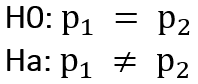

In [39]:
Image('proportions_test.png')

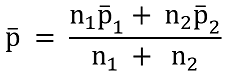

In [40]:
Image('p_.png')

In [164]:
p = sum(successes)/sum(sample_size)

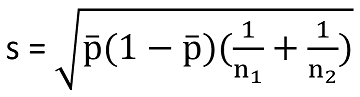

In [42]:
Image('sample_std_.png')

In [165]:
sp = np.sqrt(p*(1-p)*sum(1/sample_size))

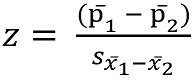

In [44]:
Image('z_statistic_.png')

In [45]:
p1 = proportions[0]
p2 = proportions[1]

In [46]:
z = (p1 - p2)/sp

In [47]:
p_value = 2*(1 - sc.norm.cdf(z))

In [48]:
α = 0.05

In [49]:
z_alpha = sc.norm.ppf(α/2)

In [50]:
# Reject H0 if z score <= z_alpha or z score >= z_alpha

if z<= z_alpha or z>= -z_alpha:
    print('Reject H0')
    print('The proportions are not equal')

else:
    print('Cannot Reject H0')

Reject H0
The proportions are not equal


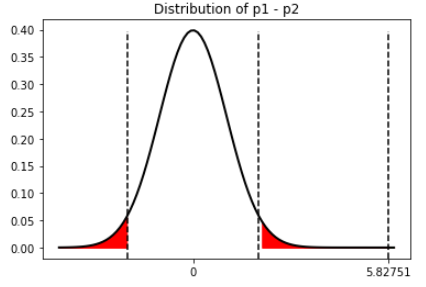

In [51]:
Image('Distribution_p1p2.png')

#### Comparing the actual delivery time against the estimated delivery time for the treatment dataset

In [52]:
order_reviews_treatment_group = ab_testing_orders_reviews[ab_testing_orders_reviews['group'] == 'Treatment']

c:\users\prateek.dasgupta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\prateek.dasgupta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\prateek.dasgupta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWa

(-10, 60)

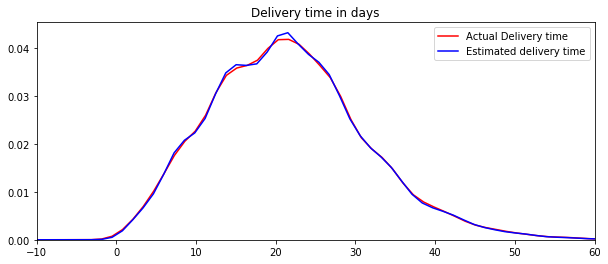

In [53]:
# Converting all the dates to pandas datetime format
order_reviews_treatment_group['order_approved_at'] = pd.to_datetime(order_reviews_treatment_group['order_approved_at'])
order_reviews_treatment_group['order_estimated_delivery_date'] = pd.to_datetime(order_reviews_treatment_group['order_estimated_delivery_date'])
order_reviews_treatment_group['order_delivered_customer_date'] = pd.to_datetime(order_reviews_treatment_group['order_delivered_customer_date'])

# Calculate actual delivery time from customer buying the product to receiveing the product
order_reviews_treatment_group['actual_delivery_time'] = (order_reviews_treatment_group['order_delivered_customer_date'] - order_reviews_treatment_group['order_approved_at']).dt.total_seconds() / 86400

# Calculating the estimated delivery time
order_reviews_treatment_group['estimated_delivery_time'] = (order_reviews_treatment_group['order_estimated_delivery_date'] - order_reviews_treatment_group['order_approved_at']).dt.total_seconds() / 86400

# Comparing the actual delivery time and estimated delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")

ax1 = sns.kdeplot(order_reviews_treatment_group['actual_delivery_time'].dropna(), color="red", label='Actual Delivery time')
ax2 = sns.kdeplot(order_reviews_treatment_group['estimated_delivery_time'].dropna(), color="blue", label='Estimated delivery time')

plt.xlim(-10, 60)

In [54]:
order_reviews_treatment_group['estimated_delivery_time']

0        99.102951
3        91.046262
5        92.478322
7        68.161111
10       65.975278
           ...    
33222    13.864167
33223     4.864132
33224     4.645590
33231     4.475498
33232     5.395058
Name: estimated_delivery_time, Length: 18235, dtype: float64

In [55]:
# Testing for a significant difference between the estimated delivery time and actual delivery time
sample_estimated_delivery_time = np.array(order_reviews_treatment_group['actual_delivery_time'])
sample_actual_delivery_time = np.array(order_reviews_treatment_group['estimated_delivery_time'])

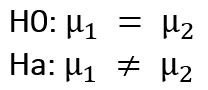

In [56]:
Image('Hypothesis_comparing_means.png')

In [57]:
# Matched sample test
t_statistic, p_value = ttest_rel(sample_estimated_delivery_time, sample_actual_delivery_time)

In [58]:
α = 0.05

# Checking p value against α
if p_value < α:
    print('P value = ', p_value)
    print('Reject H0')
    print('Populations means are not equal')
else:
    print('P value = ', p_value)
    print('Cannot Reject H0')

P value =  0.21684841987770798
Cannot Reject H0
Populations means are equal
